In [3]:
%load_ext autoreload
%autoreload 2

In [189]:
# --------------------
# Import general stuff
# --------------------
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it

from scipy.stats import kendalltau

from sklearn.model_selection import GroupKFold, GridSearchCV, RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.manifold import MDS, Isomap
from sklearn.decomposition import PCA

from rdkit.Chem.AllChem import MolFromSmiles, MolToInchiKey

# ----------------------------------
# Import Retention Order SVM classes
# ----------------------------------
from rosvm.ranksvm.rank_svm_cls import KernelRankSVC
from rosvm.ranksvm.analysis_utils import RankSVMAnalyzer
from rosvm.ranksvm.tutorial.utils import read_dataset
from rosvm.feature_extraction.featurizer_cls import CircularFPFeaturizer
from rosvm.ranksvm.kernel_utils import generalized_tanimoto_kernel, minmax_kernel

## Load Example Data

We work with the seven publicly available datasets. Those include retention times measured on different chromatographic systems.

In [190]:
X, y, mol = read_dataset("./example_data_2_mol_desc.csv")  
print("Number of Measurements:", len(y))

# Number of examples per dataset
print("Datasets:")
datasets, y_cts = y.get_unique_dss(return_counts=True)
for d, c in zip(datasets, y_cts):
    print("\t%s - #samples=%d" % (d, c))
    
for _ds in y.get_unique_dss():
    assert(np.all(np.diff(y.get_idc_for_ds(_ds)) == 1))
    
mol_inchikey = [MolToInchiKey(MolFromSmiles(_m)) for _m in mol]

Number of Measurements: 1461
Datasets:
	Boudah_et_al_2014_C18 - #samples=169
	Eawag_XBridgeC18 - #samples=320
	Eugster_et_al_2015 - #samples=221
	FEM_long - #samples=299
	LIFE_new - #samples=100
	LIFE_old - #samples=96
	RIKEN - #samples=158
	UniToyama_Atlantis - #samples=98


### Inspect Retention Order differences between the Systems

In [222]:
df_rankcorr = np.full((len(datasets), len(datasets)), fill_value=np.nan)
df_ninter = np.full((len(datasets), len(datasets)), fill_value=0)

for idx1, d1 in enumerate(datasets):
    for idx2, d2 in enumerate(datasets):
        mol1 = mol[y.get_idc_for_ds(d1)].tolist()
        mol2 = mol[y.get_idc_for_ds(d2)].tolist()
        
        rts1 = []
        rts2 = []
        
        for m in set(mol1) & set(mol2):
            rts1.append(y[y.get_idc_for_ds(d1)].get_rts()[mol1.index(m)])
            rts2.append(y[y.get_idc_for_ds(d2)].get_rts()[mol2.index(m)])
            
        df_ninter[idx1, idx2] = len(rts1)
            
        if len(rts1) < 5:
            continue
            
        acc = kendalltau(rts1, rts2)[0]
            
        df_rankcorr[idx1, idx2] = acc
        

assert(np.allclose(accs, accs.T))

df_rankcorr = pd.DataFrame(df_rankcorr, index=datasets, columns=datasets)
df_ninter = pd.DataFrame(df_ninter, index=datasets, columns=datasets)

<AxesSubplot:>

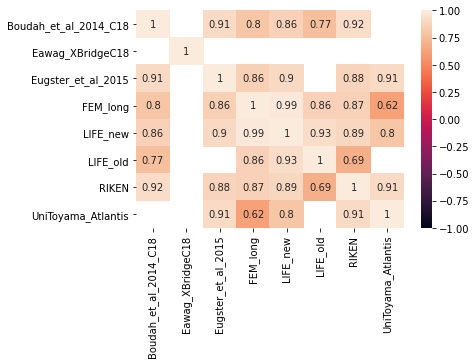

In [226]:
sns.heatmap(df_rankcorr, annot=True, vmin=-1)

<AxesSubplot:>

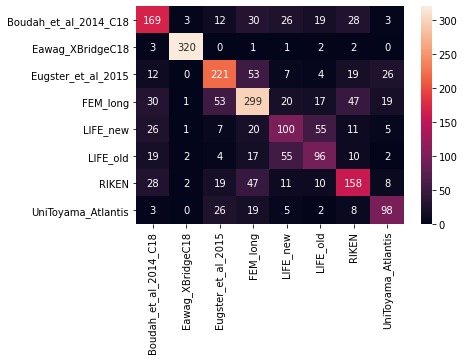

In [224]:
sns.heatmap(df_ninter, annot=True, fmt="d", vmin=0)

### Inspect the Chemical Space

We first compute the ECFP representation for all molecules and subsequently the MinMax kernel matrix. This similarity matrix is used as input for example for the Multidimensional Scaling (MDS).

In [226]:
# ECFP
X_ecfp_count = CircularFPFeaturizer(only_freq_subs=True, min_subs_freq=0.05, output_dense_matrix=True) \
    .fit_transform(mol)
print("ECFP feature matrix:", X_ecfp_count.shape)

K_ecfp = minmax_kernel(X_ecfp_count)

# Substructure
K_ss = minmax_kernel(X)

ECFP feature matrix: (1461, 112)


#### Multi-dimensional Scaling (MDS)

Get a two-dimensional embedding of the data.

In [227]:
X_ecfp_mds = MDS(dissimilarity="precomputed", n_jobs=4).fit_transform(1 - K_ecfp)
X_ss_mds = MDS(dissimilarity="precomputed", n_jobs=4).fit_transform(1 - K_ss)

For comparison, we also use the substructure fingerprint vectors for the MDS. Again through a MinMax kernel matrix.

Text(0.5, 1.0, 'Substructure')

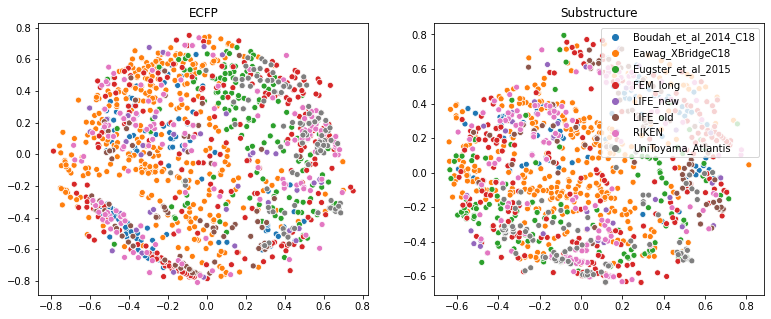

In [256]:
fig, axrr = plt.subplots(1, 2, figsize=(13, 5))
sns.scatterplot(X_ecfp_mds[:, 0], X_ecfp_mds[:, 1], hue=y.get_dss(), ax=axrr[0], legend=False)
axrr[0].set_title("ECFP")
sns.scatterplot(X_ss_mds[:, 0], X_ss_mds[:, 1], hue=y.get_dss(), ax=axrr[1])
axrr[1].set_title("Substructure")

Use both fingerprint representations show, that the chemical spaces of the different datasets overlap quite much.

#### Isomap

In [233]:
X_ecfp_iso = Isomap(metric="precomputed", n_jobs=4).fit_transform(1 - K_ecfp)
X_ss_iso = Isomap(metric="precomputed", n_jobs=4).fit_transform(1 - K_ss)

Text(0.5, 1.0, 'Substructure')

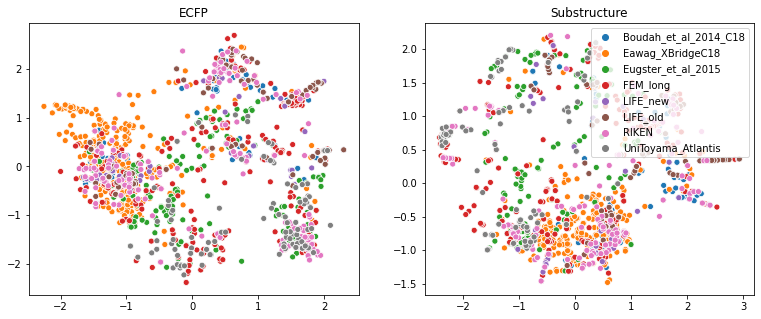

In [257]:
fig, axrr = plt.subplots(1, 2, figsize=(13, 5))
sns.scatterplot(X_ecfp_iso[:, 0], X_ecfp_iso[:, 1], hue=y.get_dss(), ax=axrr[0], legend=False)
axrr[0].set_title("ECFP")
sns.scatterplot(X_ss_iso[:, 0], X_ss_iso[:, 1], hue=y.get_dss(), ax=axrr[1])
axrr[1].set_title("Substructure")

#### PCA

Text(0.5, 1.0, 'Substructure')

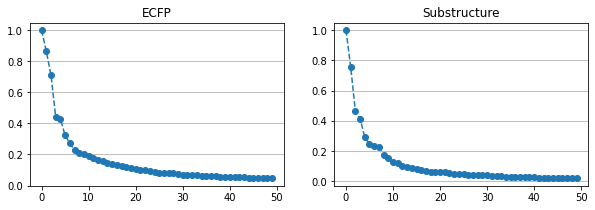

In [250]:
ecfp_pca = PCA(n_components=50).fit(X_ecfp_count)
ss_pca = PCA(n_components=50).fit(X)

fig, axrr = plt.subplots(1, 2, figsize=(10, 3))
axrr[0].plot(ecfp_pca.singular_values_ / np.max(ecfp_pca.singular_values_), 'o--')
axrr[0].grid(axis="y")
axrr[0].set_title("ECFP")
axrr[1].plot(ss_pca.singular_values_ / np.max(ss_pca.singular_values_), 'o--')
axrr[1].grid(axis="y")
axrr[1].set_title("Substructure")

Text(0.5, 1.0, 'Substructure')

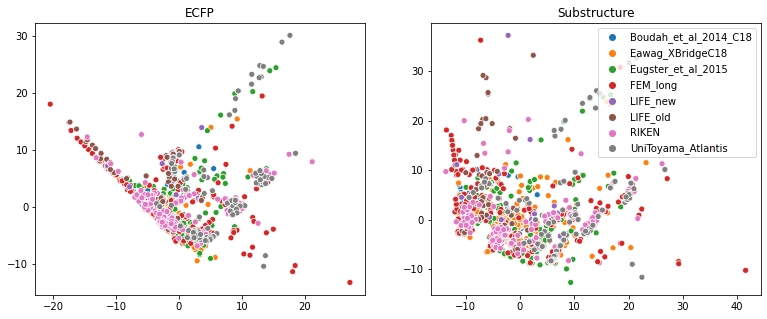

In [262]:
X_ecfp_pca = ecfp_pca.transform(X_ecfp_count)[:, :2]  # take the first two components
X_ss_pca = ss_pca.transform(X)[:, :2]  # take the first two components

fig, axrr = plt.subplots(1, 2, figsize=(13, 5))
sns.scatterplot(X_ecfp_pca[:, 0], X_ecfp_pca[:, 1], hue=y.get_dss(), ax=axrr[0], legend=False)
axrr[0].set_title("ECFP")
sns.scatterplot(X_ss_pca[:, 0], X_ss_pca[:, 1], hue=y.get_dss(), ax=axrr[1])
axrr[1].set_title("Substructure")

### Information on the Liquid-chromatographic (LC) Systems

The publications related to the datasets used here:

| Dataset | Publication | 
| :--- | --- |
| Boudah_et_al_2014_C18 | https://www.sciencedirect.com/science/article/pii/S1570023214002633 | 
| Eawag_XBridgeC18 | https://pubs.acs.org/doi/10.1021/es4044374 | 
| Eugster_et_al_2015 | https://www.sciencedirect.com/science/article/pii/S0031942214004099 |
| FEM_long | https://link.springer.com/article/10.1007%2Fs11306-011-0298-z |
| LIFE_new | https://www.sciencedirect.com/science/article/pii/S0003267012000062 |
| LIFE_old | https://www.sciencedirect.com/science/article/pii/S0003267012000062 |
| RIKEN | https://academic.oup.com/pcp/article/50/1/37/1851235 |
| UniToyama_Atlantis | https://github.com/MassBank/MassBank-data/blob/main/Univ_Toyama/TY000242.txt |

We can extract all information related to the chromatographic system from this publications.

#### Introduction 

The Book ["Liquid Chromatography: Fundamentals and Instrumentation" by S. Fanali et al. (2013)](https://books.google.fi/books?id=1gPAUzhkoqwC&dq=Liquid+Chromatography:+Fundamentals+and+Instrumentation+2013&hl=de&source=gbs_navlinks_s) states the following LC system properties as relevant to for the *selectivity* (= relative peak spacing of different molecule sin the chormatogram. I would say that also means retention order. And, the book contains examples, in which the retention order changes by varying some of these parameters) of that system:
- Temperature 
- Column (stationary phase)
- Gradient time 
- Mobile phase / Eluent
  - solvent (e.g., Methanol or Acentonetrile)
  - pH
  - additives (buffers, ...)

#### Eluent / Mobile Phase Information 

**Introduction**

As far as I understand, the mobile phase (typically) consists of a mixture of eluent A and eluent B. We can find this information in the dataset descriptions, e.g. from the publications, with typical sentences like:

- [*'[...] The gradient (water/methanol, both with 0.1% formic acid) [...]'*](https://pubs.acs.org/doi/10.1021/es4044374) -- here (I would say), eluent A = [Water (H2O)](https://pubchem.ncbi.nlm.nih.gov/compound/962) and eleuent B = [Methanol (CH4O)](https://pubchem.ncbi.nlm.nih.gov/compound/887)
- [*'[...] solvents A, 0.1% formic acid in water and B, 0.1% formic acid in acetonitrile [...]'*](https://academic.oup.com/pcp/article/50/1/37/1851235) -- here, eluent A = Water and eluent B = [Acetonitrile (ACN) (C2H3N)](https://pubchem.ncbi.nlm.nih.gov/compound/6342) 

**List of Eluents for our Datasets**

| Dataset | Eluent A | Eluent B | Additive A | Additive B | pH |
| --- | --- | --- | --- | --- | --- |
| Boudah_et_al_2014_C18 | Water (H2O) | Acetonitrile (ACN) (C2H3N) | Formic Acid (CH2O2) | Formic Acid (CH2O2) |
| Eawag_XBridgeC18 | Water (H2O) | Methanol (CH4O) | Formic Acid (CH2O2) | Formic Acid (CH2O2) |
| Eugster_et_al_2015 | Water (H2O) | Acetonitrile (ACN) (C2H3N) | Formic Acid (CH2O2) | Formic Acid (CH2O2) |
| FEM_long | Water (H2O) | Methanol (CH4O) | Formic Acid (CH2O2) | Formic Acid (CH2O2) |
| LIFE_new | Water (H2O) | 30% Methanol (CH4O) + 70% Acetonitrile (ACN) (C2H3N) | Formic Acid (CH2O2) | Formic Acid (CH2O2) |
| LIFE_old | Water (H2O) | 20% [Acetone (C3H6O)](https://pubchem.ncbi.nlm.nih.gov/compound/180) + 80% Acetonitrile (ACN) (C2H3N) | Formic Acid (CH2O2) | Formic Acid (CH2O2) |
| RIKEN | Water (H2O) | Acetonitrile (ACN) (C2H3N) | Formic Acid (CH2O2) | Formic Acid (CH2O2) |
| UniToyama_Atlantis | Water (H2O) | Acetonitrile (ACN) (C2H3N) | Ammonium Acetate (C2H7NO2) | -

- [How does the eluent gets its pH?](https://hplctips.blogspot.com/2013/02/ph-of-hplc-mobile-phase-solutions-and.html)

**Similarity Calculation of Eluent Configurations**

Multiple approaches could be used to calculate the similarity between the eluent configuration of two chromatographic systems:
- *one-hot-encoding*: two eluent configurations (or separately for A and B eluent) have similarity 1 of they are equal and 0 otherwise
- *feature representation of the eleunts*: the features are used to express how similar two eluents are
| Eluent | SMILES | LogP (from PubChem) | Hyd. Bond Donors | Hyd. Bond Acceptors | #H | #C | #O | #N |
| --- | --- | ---: | ---: | ---: |---: | ---: | ---: | ---: | 
| Water (H2O) | O | $-1.38$ | 1 | 1 | 2 | 0 | 1 | 0 |
| Methanol (CH4O) | CO | $-0.77$ | 1 | 1 | 4 | 1 | 1 | 0 |
| Acetonitrile (ACN) (C2H3N) | CC#N | $-0.34$ | 0 | 1 | 3 | 2 | 0 | 1 |
| Acetone (C3H6O) | CC(=O)C | $-0.24$ | 0 | 1 | 6 | 3 | 1 | 0 |

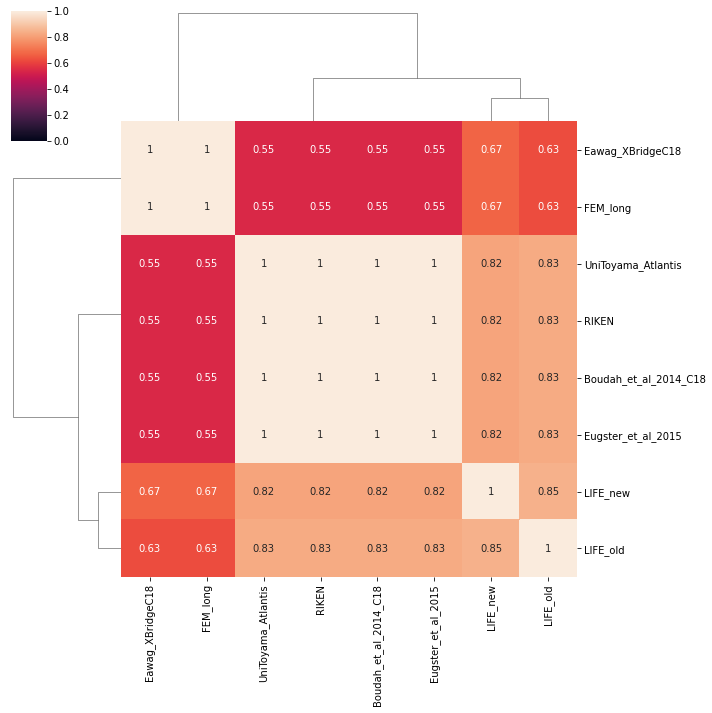

In [39]:
from sklearn.metrics.pairwise import rbf_kernel
k_eluent = generalized_tanimoto_kernel

eluents = {
    "LIFE_old": 0.2 * np.array([-0.24, 0, 6, 3, 1, 0]) + 0.8 * np.array([-0.34, 0, 3, 2, 0, 1]),
    "LIFE_new": 0.3 * np.array([-0.77, 1, 4, 2, 1, 0]) + 0.7 * np.array([-0.34, 0, 3, 2, 0, 1]),
    "Boudah_et_al_2014_C18": np.array([-0.34, 0, 3, 2, 0, 1]),
    "RIKEN": np.array([-0.34, 0, 3, 2, 0, 1]),
    "Eugster_et_al_2015": np.array([-0.34, 0, 3, 2, 0, 1]),
    "Eawag_XBridgeC18": np.array([-0.77, 1, 4, 2, 1, 0]),
    "UniToyama_Atlantis": np.array([-0.34, 0, 3, 2, 0, 1]),
    "FEM_long": np.array([-0.77, 1, 4, 2, 1, 0])
}

df_K_eluents = pd.DataFrame(k_eluent(np.array(list(eluents.values()))), 
                            index=list(eluents.keys()), 
                            columns=list(eluents.keys())) \
    .sort_index(axis=0).sort_index(axis=1)  # sort rows and columns
sns.clustermap(df_K_eluents, annot=True, vmax=1, vmin=0)

#eluents = {
# "H20": np.array([-1.38, 1, 2, 0, 1, 0]), 
#    "CH4O": np.array([-0.77, 1, 4, 2, 1, 0]), 
#    "C2H3N": np.array([-0.34, 0, 3, 2, 0, 1]), 
#    "C3H6O": np.array([-0.24, 0, 6, 3, 1, 0]), 
#}

#from rdkit.Chem.EState.Fingerprinter import FingerprintMol as EstateFingerprinter
#from rdkit.Chem.AllChem import MolFromSmiles
#for el, smi in [("CH4O", "CO"), ("C2H3N", "CC#N"), ("C3H6O", "CC(=O)C")]:
#    eluents[el][-1] = EstateFingerprinter(MolFromSmiles(smi))[1][6]

#### Gradient Information 


**Encoding**

Let's consider an example gradient description: 

[``90/10 at 0 min, 50/50 at 4 min, 5/95 at 17 min, 5/95 at 25 min, 90/10 at 25.1 min, 90/10 at 30 min``](https://github.com/MassBank/MassBank-data/blob/main/Eawag/EA000401.txt)

We represent the gradient as matrix: 

$$
\mathbf{G}=
    \left[
        \begin{matrix}
            0.0 & 4.0 & 17.0 & 25.0 & 25.1 & 30.0 \\
            10.0 & 50.0 & 95.0 & 95.0 & 10.0 & 10.0
        \end{matrix}
    \right],
$$

where the first row stores the time points at which the *eluent B* be represents a certain percentage of the mobile phase. This percentage is stored in the second row. The in dual mixture, we can deduce the percentage of eluent A from the percentage of eluent B.

In [26]:
# Gradients: time t and corresponding percentage of eluent B
grads = {
    "LIFE_old": np.array([[0.0, 5.0, 5.5, 6.0], [0.0, 100.0, 0.0, 0.0]]),
    "LIFE_new": np.array([[0.0, 1.0, 2.0, 3.0, 4.0, 4.5, 5.0, 6.4, 6.6, 6.8, 7.0],
                          [5, 8, 15, 40, 70, 100, 100, 100, 5.0, 5.0, 5.0]]),
    "Boudah_et_al_2014_C18": np.array([[0.0, 2.0, 20, 24], [5, 5, 100, 100]]),
    "RIKEN": np.array([[0.0, 0.25, 0.4, 0.8, 1.9, 2.1],
                       [0.0, 0.0, 9.0, 17.0, 100.0, 100.0]]),
    "Eugster_et_al_2015": np.array([[0.0, 30.0], [5, 95]]),
    "Eawag_XBridgeC18": np.array([[0.0, 4.0, 17.0, 25.0, 25.1, 30.0],
                                  [10.0, 50.0, 95.0, 95.0, 10.0, 10.0]]),
    "UniToyama_Atlantis": np.array([[0.0, 40.0], [10.0, 100.0]]),
    "FEM_long": np.array([[0.0, 6.0, 56.0, 60.0], [0.0, 0.0, 100.0, 100.0]])
}

**Some observations:**
- gradients have different length (also called "gradient time"), e.g. varying from ~5min to ~60min
- some gradients are simple linear gradients with the transition from eluent A to eleunt B over the gradient time
- some gradients are, however, more complex picewise linear functions 

| Dataset | Gradient-time |
| --- | ---: | 
| Boudah_et_al_2014_C18 | 24 min | 
| Eawag_XBridgeC18 | 30 min |
| Eugster_et_al_2015 | 30 min | 
| FEM_long | 60 min |
| LIFE_new | 7 min | 
| LIFE_old | 6 min | 
| RIKEN | 2.1 min | 
| UniToyama_Atlantis | 40 min | 

**Similarity Calculation of Gradient Shapes**

One approach to calculate the similarity between gradients, is to model their fraction of eluent B over the (gradient) run-time. For that, we set up a picewise linear function, using the [NumPy "interp"](https://numpy.org/doc/stable/reference/generated/numpy.interp.html) function and the gradient points provided for each dataset. 

This allows us to two-gradients by their shapes using an appropriate similarity measure. Here, we apply the [generalized Tanimoto kernel](https://arxiv.org/abs/2007.05943) for this. 

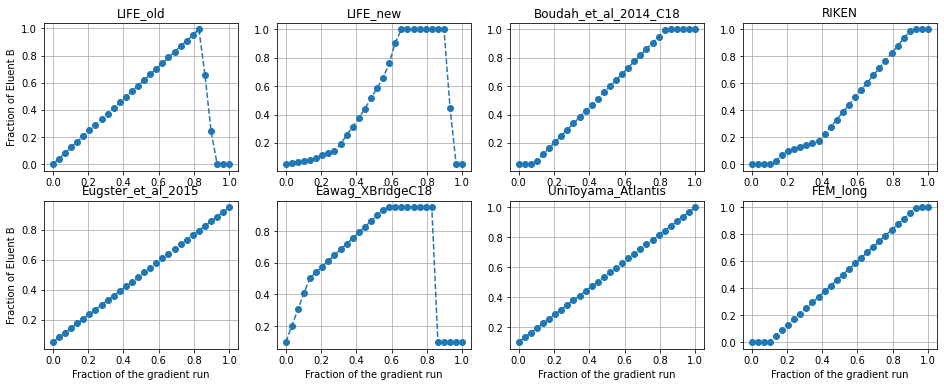

In [28]:
n_samples_points = 30
grads_as_funcs = {
    k: np.interp(np.linspace(0, 1, n_samples_points), v[0] / np.max(v[0]), v[1] / 100)
    for k, v in grads.items()
}

fig, axrr = plt.subplots(2, 4, figsize=(16, 6))

for idx, (k, fx) in enumerate(grads_as_funcs.items()):
    r, c = np.unravel_index(idx, shape=axrr.shape)
    
    axrr[r, c].plot(np.linspace(0, 1, n_samples_points), fx, 'o--', label=k)
    
    if r == 1:
        axrr[r, c].set_xlabel("Fraction of the gradient run")
    if c == 0:
        axrr[r, c].set_ylabel("Fraction of Eluent B")
    axrr[r, c].set_title(k)
    axrr[r, c].grid() # (axis="y")

plt.show()
# axrr[0, 0].legend()
# plt.show()

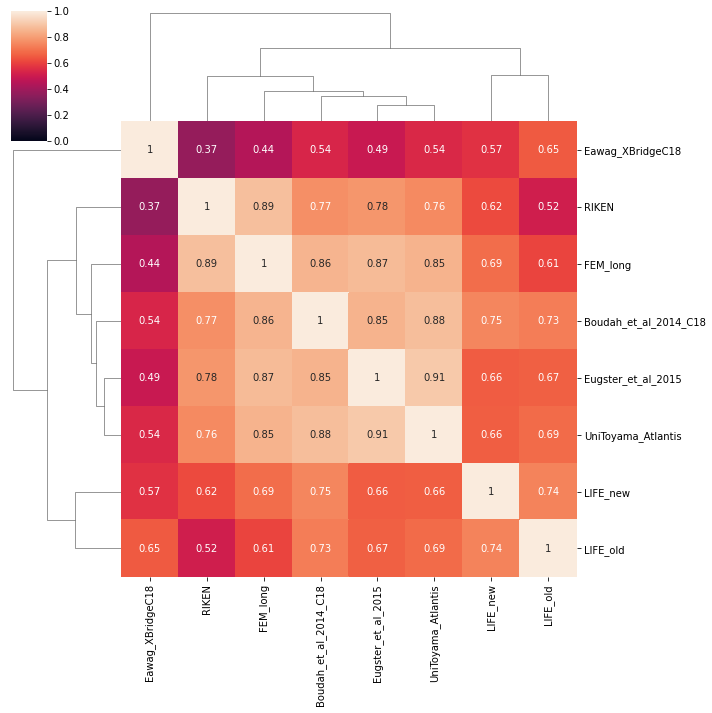

In [35]:
k_grad = generalized_tanimoto_kernel

df_K_gradients = pd.DataFrame(k_grad(np.array(list(grads_as_funcs.values()))), 
                              index=list(grads_as_funcs.keys()), 
                              columns=list(grads_as_funcs.keys())) \
    .sort_index(axis=0).sort_index(axis=1)  # sort rows and columns
sns.clustermap(df_K_gradients, annot=True, vmax=1, vmin=0)

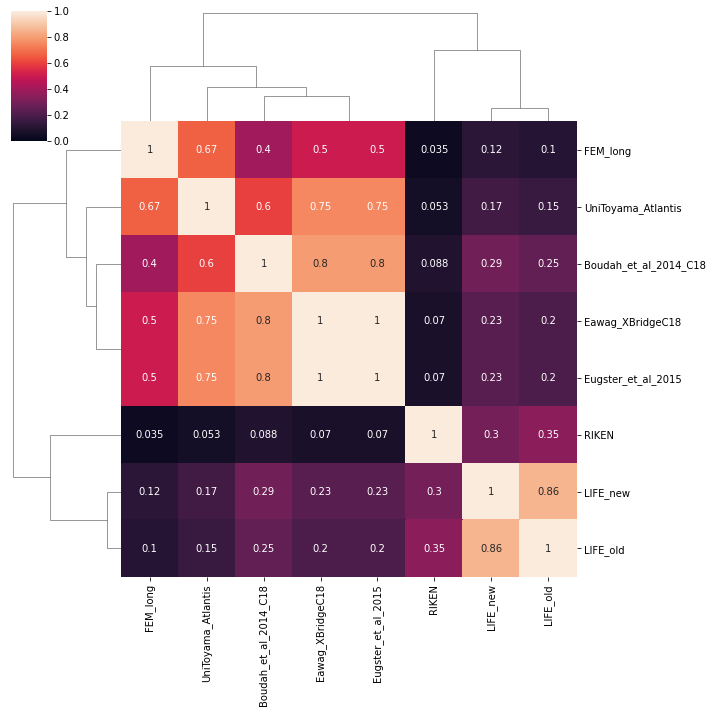

In [40]:
grad_times = {
    "LIFE_old": np.array([6]),
    "LIFE_new": np.array([7.0]),
    "Boudah_et_al_2014_C18": np.array([24]),
    "RIKEN": np.array([2.1]),
    "Eugster_et_al_2015": np.array([30]),
    "Eawag_XBridgeC18": np.array([30]),
    "UniToyama_Atlantis": np.array([40]),
    "FEM_long": np.array([60])
}

k_grad_times = minmax_kernel

df_K_gradient_times = pd.DataFrame(k_grad_times(np.array(list(grad_times.values()))), 
                              index=list(grad_times.keys()), 
                              columns=list(grad_times.keys())) \
    .sort_index(axis=0).sort_index(axis=1)  # sort rows and columns
sns.clustermap(df_K_gradient_times, annot=True, vmax=1, vmin=0)

<AxesSubplot:>

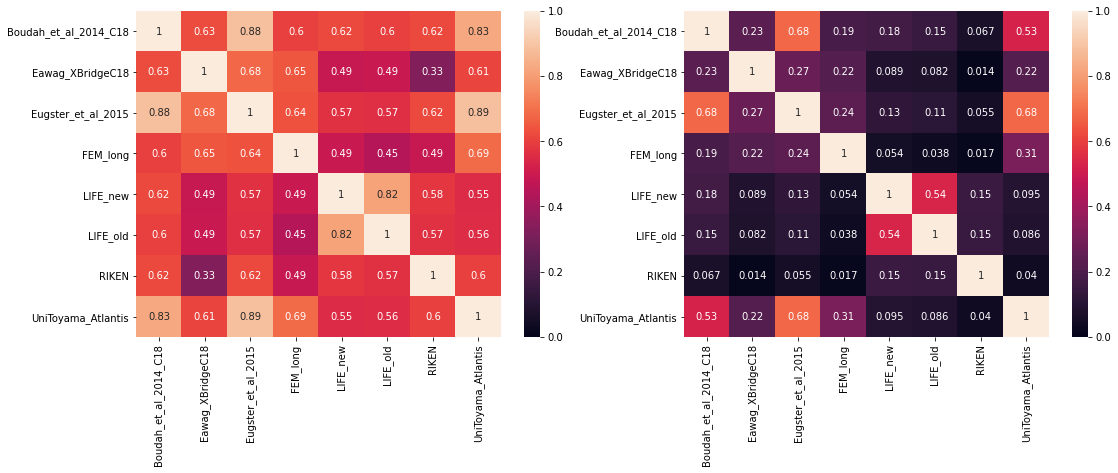

In [311]:
fix, axrr = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap((df_K_eluents + df_K_gradients + df_K_gradient_times) / 3, annot=True, ax=axrr[0], vmin=0)
sns.heatmap((df_K_eluents * df_K_gradients * df_K_gradient_times), annot=True, ax=axrr[1], vmin=0)

(0.41027379608297393, 0.012945163932509619)


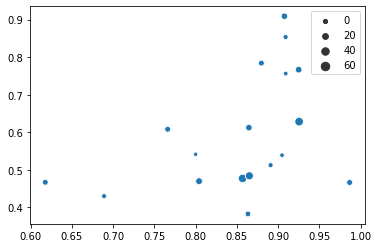

In [330]:
from scipy.stats import pearsonr, spearmanr

_xx = df_rankcorr.values.flatten()

_yy = ((df_K_gradients * df_K_eluents)).values.flatten()
# _yy = ((df_K_gradients + df_K_eluents) / 2).values.flatten()

_ss = df_ninter.values.flatten()

sns.scatterplot(_xx[(~ np.isnan(_xx)) & (_yy != 1.0)], _yy[(~ np.isnan(_xx)) & (_yy != 1.0)], size=_ss[(~ np.isnan(_xx)) & (_yy != 1.0)])

print(pearsonr(_xx[(~ np.isnan(_xx)) & (_yy != 1.0)],
               _yy[(~ np.isnan(_xx)) & (_yy != 1.0)]))

#### Column / Stationary Phase Information 

The utilized column influences the separation of the molecules. Here is a description of the columns used for the different datasets:

| Dataset | Flowrate | Column length | Diameter | Column | Temperature |  
| --- | --- | --- | --- | --- |  --- | 
| Boudah_et_al_2014_C18 | 500 | 150 | 2.1 | HYPERSIL GOLD C18 | 30 |
| Eawag_XBridgeC18 | 200 | 50 | 2.1 | WATERS XBRIDGE C18 | 30 |
| Eugster_et_al_2015 | 460 | 150 | 2.1 | WATERS ACQUITY UPLC BEH C18 | 40 |
| FEM_long | 300 | 100 | 2.1 | WATERS ACQUITY UPLC HSS T3 C18 | 30 |
| LIFE_new | 770 | 100 | 2.1 | WATERS ACQUITY UPLC HSS T3 C18 | 50 |
| LIFE_old | 400 | 100 | 2.1 | WATERS ACQUITY UPLC BEH C18 | 65 |
| RIKEN | 240 | - | - | WATERS ACQUITY UPLC BEH C18 | 38 | 
| UniToyama_Atlantis | 200 | 150 | 2.1 | WATERS ATLANTIS T3 | 40 |

**Similarity Calculation of Columns**

We can calculate some kind of kernel in the flowrate, column length, diameter and temperature values. For the columns itself it might be a bit more tricky. There is a column classification system using the [Hydrophobic Subtraction Model (HSM)](http://www.hplccolumns.org/). The HSM assigns a seven-dimensional feature vector to each column. It (somehow) expresses its separation behavior. Alternatively, we can chose a one-hot-encoding for columns as well. However, there might be more properties directly related to the [stationary phase of a particular column](https://pubs.acs.org/doi/abs/10.1021/acs.chemrev.8b00246). 

Load the descriptors of the different systems

In [83]:
def read_system_descriptors(fn, grads_as_funcs):
    # LogP values are taken from PubChem
    logP = {"H2O": -1.38, "CH4O": -0.77, "C3H6O": -0.24, "C2H3N": -0.34}
    
    # Read and parse the information for the column (stationary phase) used in the chromatographic system
    df_col = pd.read_csv(fn, sep="\t")[["name", "temperature", "flowrate", "desc_hsm"]]
    df_col[["hsm_1", "hsm_2", "hsm_3", "hsm_4", "hsm_5", "hsm_6", "hsm_7"]] = df_col.desc_hsm.str.split(",", expand=True)
    df_col = df_col.drop("desc_hsm", axis=1)
    df_col = df_col.rename(columns={"name": "dataset"})
    df_col = df_col.sort_values(by="dataset")

    # Read the information related to the mobile phase
    df_elu = pd.read_csv(fn, sep="\t", usecols=["name", "eluent_A_mol", "eluent_A_con", "eluent_B_mol", "eluent_B_con"], 
                         dtype={"name": str, "eluent_A_mol": str, "eluent_A_con": str, 
                                "eluent_B_mol": str, "eluent_B_con": str})
    df_elu = df_elu.rename(columns={"name": "dataset"})
    df_elu = df_elu.set_index("dataset")
    
    # Replace the mobile phase molecules with their logp values
    df_elu = df_elu.apply(lambda row: [np.average([logP[v] for v in row[0].split(",")], 
                                     weights=np.array([v for v in row[1].split(",")], dtype="float") / 100.),
                          np.average([logP[v] for v in row[2].split(",")], 
                                     weights=np.array([v for v in row[3].split(",")], dtype="float") / 100.)],
                          axis=1, result_type="expand") \
        .reset_index() \
        .rename(columns={0: "eluent_A_logp", 1: "eluent_B_logp"}) \
        .sort_values(by="dataset")
    
    df_elu_grad = df_elu.apply(lambda row: [row[0]] + 
                               ((1 - grads_as_funcs[row[0]]) * row[1] + grads_as_funcs[row[0]] * row[2]).tolist(),
             axis=1, result_type="expand") \
        .rename(columns={0: "dataset"}) \
        .sort_values(by="dataset")
    
    return df_col, df_elu, df_elu_grad

df_col, df_elu, df_elu_grad = read_system_descriptors("./example_data_2_cs_desc.csv", grads_as_funcs)

<AxesSubplot:>

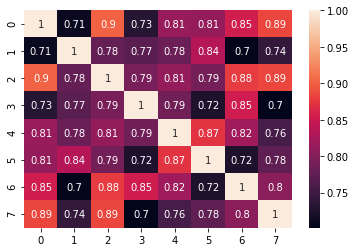

In [84]:
sns.heatmap(generalized_tanimoto_kernel(df_elu_grad.iloc[:, 1:].values), annot=True)

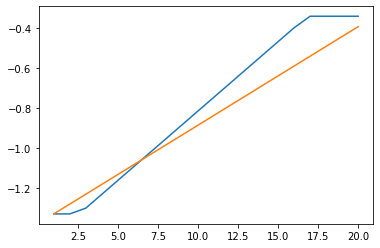

In [164]:
plt.plot(df_elu_grad.iloc[0,1:])
plt.plot(df_elu_grad.iloc[2,1:])

<AxesSubplot:>

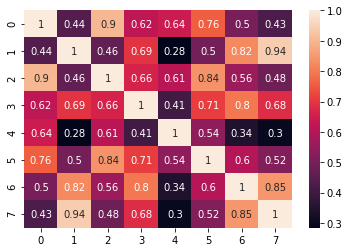

In [68]:
sns.heatmap(generalized_tanimoto_kernel(df_col.iloc[:, 1:].values.astype("float")), annot=True)

In [146]:
X_col = np.repeat(df_col.iloc[:, 1:4].values.astype("float"), y_cts, axis=0)
X_elu = np.repeat(df_elu.iloc[:, 1:].values.astype("float"), y_cts, axis=0)
X_elu_grad = np.repeat(df_elu_grad.iloc[:, 1:].values.astype("float"), y_cts, axis=0)

In [87]:
generalized_tanimoto_kernel(X_elu)

array([[1.        , 1.        , 1.        , ..., 0.88502448, 0.88502448,
        0.88502448],
       [1.        , 1.        , 1.        , ..., 0.88502448, 0.88502448,
        0.88502448],
       [1.        , 1.        , 1.        , ..., 0.88502448, 0.88502448,
        0.88502448],
       ...,
       [0.88502448, 0.88502448, 0.88502448, ..., 1.        , 1.        ,
        1.        ],
       [0.88502448, 0.88502448, 0.88502448, ..., 1.        , 1.        ,
        1.        ],
       [0.88502448, 0.88502448, 0.88502448, ..., 1.        , 1.        ,
        1.        ]])

## Evaluate different Models

Here, we are evaluating different RankSVM models with and without additional features of the chromatographic system. Thereby we run a Leave-Dataset-Out evaluation. 

```Python
C_grid = [2**-4, ..., 2**4]
sim_threshold = quantile(pairwise_similarities(X, X), 0.9)

for dataset in DATASETS:
    # TEST-SET: Get molecule, features and labels for the current dataset
    X_test, y_test, mols_test = X[dataset], y[dataset], mols[dataset]
    
    # TRAIN-SET: 
    X_train, y_train, mols_train = X[~dataset], y[~dataset], mols[~dataset]
    
    # Remove very molecules from the training set, that are too similar to the test set
    sim_train_to_test = pairwise_similarities(X_train, X_test)
    X_train = X_train[sim_train_to_test >= sim_treshold]
    y_train = y_train[sim_train_to_test >= sim_treshold]
    mols_train = mols_train[sim_train_to_test < sim_treshold]
    
    # Train the RankSVM model 
    model = gridsearchcv(X_train, y_train, mols_train, C_grid)
    
    # Calcualte the test set performance 
    perf_test[dataset] = model.score(X_test, y_test)
```

### Calculate the different Kernels

In [57]:
K_fps = generalized_tanimoto_kernel(X)  # n_samples x n_samples
K_eluents = np.repeat(np.repeat(df_K_eluents.values, y_cts, axis=0), y_cts, axis=1)
K_gradients = np.repeat(np.repeat(df_K_gradients.values, y_cts, axis=0), y_cts, axis=1)
K_gradient_times = np.repeat(np.repeat(df_K_gradient_times.values, y_cts, axis=0), y_cts, axis=1)

In [157]:
import itertools as it
from joblib import Parallel, delayed

def _score(K, y, train, test, C, pair_generation):
    K_train = K[np.ix_(train, train)]
    K_test = K[np.ix_(test, train)]
    y_train = y[train]
    y_test = y[test]
    
    return KernelRankSVC(C=C, random_state=len(K_train), pair_generation=pair_generation).fit(K_train, y_train).score(K_test, y_test)

def get_ranksvm_with_optimal_C(K, y, n_splits=3, n_rep=3, pair_generation="random"):
    C_grid = 2.0 ** np.arange(-3, 4)
    
    scores = Parallel(n_jobs=4)(delayed(_score)(K, y, train, test, C, pair_generation) 
                                for (train, test), C 
                                in it.product(RepeatedKFold(n_repeats=n_rep, n_splits=n_splits, random_state=len(K)).split(y), C_grid))
    scores = np.array(scores).reshape((n_rep * n_splits, len(C_grid)))
    
    #scores = np.full((n_rep * n_splits, len(C_grid)), fill_value=np.nan)
    
    #for fold_idx, (train, test) in enumerate(RepeatedKFold(n_repeats=n_rep, n_splits=n_splits, random_state=len(K)).split(y)):
    #    K_train = K[np.ix_(train, train)]
    #    K_test = K[np.ix_(test, train)]
    #    y_train = y[train]
    #    y_test = y[test]
        
    #    for C_idx, C in enumerate(C_grid):
    #        scores[fold_idx, C_idx] = KernelRankSVC(C=C, random_state=len(K_train), pair_generation=pair_generation).fit(K_train, y_train).score(K_test, y_test)
            
    scores = np.mean(scores, axis=0)
    C_best = C_grid[np.argmax(scores)]
    
    #print(C_grid)
    #print(scores)
    #print("Best C", C_best)
    
    return KernelRankSVC(C=C_best, random_state=len(K)).fit(K, y)

### Evaluate Single System RankSVM Performance

In [158]:
scores = {}

for idx, ds in enumerate(y.get_unique_dss()):
    print("Dataset: '%s' (%d/%d)" % (ds, idx + 1, len(y.get_unique_dss())))
    
    # Get data belonging to this system
    ds_idc = y.get_idc_for_ds(ds)
    K_fps_ds = K_fps[np.ix_(ds_idc, ds_idc)]
    y_ds = y[ds_idc]
    
    # Repeated KFold to evaluate the performance on the current dataset
    scores[ds] = []
    for train, test in RepeatedKFold(n_repeats=3, n_splits=5, random_state=idx).split(y_ds):        
        scores[ds].append(get_ranksvm_with_optimal_C(K_fps_ds[np.ix_(train, train)], y_ds[train]).score(K_fps_ds[np.ix_(test, train)], y_ds[test]))
       
    print("%.3f (+/- %.3f)" % (np.mean(scores[ds]), np.std(scores[ds])))
        
print(pd.DataFrame(scores).mean(axis=0))

scores_single_system = scores

Dataset: 'Boudah_et_al_2014_C18' (1/8)
0.805 (+/- 0.033)
Dataset: 'Eawag_XBridgeC18' (2/8)
0.850 (+/- 0.016)
Dataset: 'Eugster_et_al_2015' (3/8)
0.894 (+/- 0.019)
Dataset: 'FEM_long' (4/8)
0.906 (+/- 0.012)
Dataset: 'LIFE_new' (5/8)
0.817 (+/- 0.051)
Dataset: 'LIFE_old' (6/8)
0.796 (+/- 0.092)
Dataset: 'RIKEN' (7/8)
0.833 (+/- 0.033)
Dataset: 'UniToyama_Atlantis' (8/8)
0.819 (+/- 0.040)
Boudah_et_al_2014_C18    0.805119
Eawag_XBridgeC18         0.850303
Eugster_et_al_2015       0.893641
FEM_long                 0.906400
LIFE_new                 0.817380
LIFE_old                 0.796405
RIKEN                    0.832760
UniToyama_Atlantis       0.818694
dtype: float64


### Evaluate Multi System RankSVM Performance

**Without System Descriptors**

In [167]:
scores = {}

for idx, ds in enumerate(y.get_unique_dss()):
    print("Dataset: '%s' (%d/%d)" % (ds, idx + 1, len(y.get_unique_dss())))
    
    # Get data belonging to this system
    ds_idc = y.get_idc_for_ds(ds)
    K_fps_ds = K_fps[ds_idc]
    y_ds = y[ds_idc]
    mol_ds = mol[ds_idc]
    
    # Repeated KFold to evaluate the performance on the current dataset
    scores[ds] = []
    for _, test in RepeatedKFold(n_repeats=3, n_splits=5, random_state=idx).split(mol_ds): 
        mol_ds_test = set(mol_ds[test])
        train = [_i for _i in range(len(y)) if mol[_i] not in mol_ds_test]
        
        scores[ds].append(get_ranksvm_with_optimal_C(K_fps[np.ix_(train, train)], y[train]).score(K_fps_ds[np.ix_(test, train)], y_ds[test]))
       
    print("%.3f (+/- %.3f)" % (np.mean(scores[ds]), np.std(scores[ds])))
        
print(pd.DataFrame(scores).mean(axis=0))

scores_multi_system = scores

Dataset: 'Boudah_et_al_2014_C18' (1/8)
0.850 (+/- 0.022)
Dataset: 'Eawag_XBridgeC18' (2/8)
0.849 (+/- 0.015)
Dataset: 'Eugster_et_al_2015' (3/8)
0.898 (+/- 0.022)
Dataset: 'FEM_long' (4/8)
0.913 (+/- 0.011)
Dataset: 'LIFE_new' (5/8)
0.896 (+/- 0.042)
Dataset: 'LIFE_old' (6/8)
0.890 (+/- 0.029)
Dataset: 'RIKEN' (7/8)
0.868 (+/- 0.032)
Dataset: 'UniToyama_Atlantis' (8/8)
0.851 (+/- 0.041)
Boudah_et_al_2014_C18    0.849678
Eawag_XBridgeC18         0.848916
Eugster_et_al_2015       0.897796
FEM_long                 0.912787
LIFE_new                 0.896046
LIFE_old                 0.889945
RIKEN                    0.868466
UniToyama_Atlantis       0.850663
dtype: float64


**With System Descriptors**

In [280]:
scores = {}

K_sys = (K_eluents + K_gradients) / 2

for idx, ds in enumerate(y.get_unique_dss()):
    print("Dataset: '%s' (%d/%d)" % (ds, idx + 1, len(y.get_unique_dss())))
    
    # Get data belonging to this system
    ds_idc = y.get_idc_for_ds(ds)
    K_fps_ds = K_fps[ds_idc]
    K_sys_ds = K_sys[ds_idc]
    y_ds = y[ds_idc]
    mol_ds = mol[ds_idc]
    
    # Repeated KFold to evaluate the performance on the current dataset
    scores[ds] = []
    for _, test in RepeatedKFold(n_repeats=3, n_splits=5, random_state=idx).split(mol_ds): 
        mol_ds_test = set(mol_ds[test])
        train = [_i for _i in range(len(y)) if mol[_i] not in mol_ds_test]
        
        scores[ds].append(get_ranksvm_with_optimal_C(K_fps[np.ix_(train, train)] * K_sys[np.ix_(train, train)], y[train]) \
            .score(K_fps_ds[np.ix_(test, train)] * K_sys_ds[np.ix_(test, train)], y_ds[test]))
       
    print("%.3f (+/- %.3f)" % (np.mean(scores[ds]), np.std(scores[ds])))
        
print(pd.DataFrame(scores).mean(axis=0))

scores_multi_system_with_sys_desc_add = scores

Dataset: 'Boudah_et_al_2014_C18' (1/8)
0.852 (+/- 0.028)
Dataset: 'Eawag_XBridgeC18' (2/8)
0.851 (+/- 0.015)
Dataset: 'Eugster_et_al_2015' (3/8)
0.904 (+/- 0.019)
Dataset: 'FEM_long' (4/8)
0.918 (+/- 0.013)
Dataset: 'LIFE_new' (5/8)
0.897 (+/- 0.045)
Dataset: 'LIFE_old' (6/8)
0.879 (+/- 0.027)
Dataset: 'RIKEN' (7/8)
0.869 (+/- 0.026)
Dataset: 'UniToyama_Atlantis' (8/8)
0.866 (+/- 0.033)
Boudah_et_al_2014_C18    0.851617
Eawag_XBridgeC18         0.851180
Eugster_et_al_2015       0.903981
FEM_long                 0.918409
LIFE_new                 0.896736
LIFE_old                 0.879330
RIKEN                    0.868540
UniToyama_Atlantis       0.866413
dtype: float64


In [273]:
scores = {}

K_sys = K_eluents * K_gradients

for idx, ds in enumerate(y.get_unique_dss()):
    print("Dataset: '%s' (%d/%d)" % (ds, idx + 1, len(y.get_unique_dss())))
    
    # Get data belonging to this system
    ds_idc = y.get_idc_for_ds(ds)
    K_fps_ds = K_fps[ds_idc]
    K_sys_ds = K_sys[ds_idc]
    y_ds = y[ds_idc]
    mol_ds = mol[ds_idc]
    
    # Repeated KFold to evaluate the performance on the current dataset
    scores[ds] = []
    for _, test in RepeatedKFold(n_repeats=3, n_splits=5, random_state=idx).split(mol_ds): 
        mol_ds_test = set(mol_ds[test])
        train = [_i for _i in range(len(y)) if mol[_i] not in mol_ds_test]
        
        scores[ds].append(get_ranksvm_with_optimal_C(K_fps[np.ix_(train, train)] * K_sys[np.ix_(train, train)], y[train]) \
            .score(K_fps_ds[np.ix_(test, train)] * K_sys_ds[np.ix_(test, train)], y_ds[test]))
       
    print("%.3f (+/- %.3f)" % (np.mean(scores[ds]), np.std(scores[ds])))
        
print(pd.DataFrame(scores).mean(axis=0))

scores_multi_system_with_sys_desc_multi = scores

Dataset: 'Boudah_et_al_2014_C18' (1/8)
0.853 (+/- 0.028)
Dataset: 'Eawag_XBridgeC18' (2/8)
0.855 (+/- 0.014)
Dataset: 'Eugster_et_al_2015' (3/8)
0.907 (+/- 0.017)
Dataset: 'FEM_long' (4/8)
0.915 (+/- 0.010)
Dataset: 'LIFE_new' (5/8)
0.888 (+/- 0.045)
Dataset: 'LIFE_old' (6/8)
0.879 (+/- 0.032)
Dataset: 'RIKEN' (7/8)
0.867 (+/- 0.032)
Dataset: 'UniToyama_Atlantis' (8/8)
0.869 (+/- 0.033)
Boudah_et_al_2014_C18    0.852687
Eawag_XBridgeC18         0.854670
Eugster_et_al_2015       0.906936
FEM_long                 0.915426
LIFE_new                 0.887587
LIFE_old                 0.878954
RIKEN                    0.867377
UniToyama_Atlantis       0.868752
dtype: float64


In [334]:
scores = {}

K_sys = np.repeat(np.repeat(df_rankcorr.fillna(0.0).values, y_cts, axis=0), y_cts, axis=1)

for idx, ds in enumerate(y.get_unique_dss()):
    print("Dataset: '%s' (%d/%d)" % (ds, idx + 1, len(y.get_unique_dss())))
    
    # Get data belonging to this system
    ds_idc = y.get_idc_for_ds(ds)
    K_fps_ds = K_fps[ds_idc]
    K_sys_ds = K_sys[ds_idc]
    y_ds = y[ds_idc]
    mol_ds = mol[ds_idc]
    
    # Repeated KFold to evaluate the performance on the current dataset
    scores[ds] = []
    for _, test in RepeatedKFold(n_repeats=3, n_splits=5, random_state=idx).split(mol_ds): 
        mol_ds_test = set(mol_ds[test])
        train = [_i for _i in range(len(y)) if mol[_i] not in mol_ds_test]
        
        scores[ds].append(get_ranksvm_with_optimal_C(K_fps[np.ix_(train, train)] * K_sys[np.ix_(train, train)], y[train]) \
            .score(K_fps_ds[np.ix_(test, train)] * K_sys_ds[np.ix_(test, train)], y_ds[test]))
       
    print("%.3f (+/- %.3f)" % (np.mean(scores[ds]), np.std(scores[ds])))
        
print(pd.DataFrame(scores).mean(axis=0))

scores_multi_system_with_sys_desc_corr = scores

Dataset: 'Boudah_et_al_2014_C18' (1/8)
0.791 (+/- 0.034)
Dataset: 'Eawag_XBridgeC18' (2/8)
0.832 (+/- 0.014)
Dataset: 'Eugster_et_al_2015' (3/8)
0.836 (+/- 0.035)
Dataset: 'FEM_long' (4/8)
0.898 (+/- 0.015)
Dataset: 'LIFE_new' (5/8)
0.865 (+/- 0.043)
Dataset: 'LIFE_old' (6/8)
0.723 (+/- 0.077)
Dataset: 'RIKEN' (7/8)
0.830 (+/- 0.024)
Dataset: 'UniToyama_Atlantis' (8/8)
0.738 (+/- 0.081)
Boudah_et_al_2014_C18    0.790767
Eawag_XBridgeC18         0.832472
Eugster_et_al_2015       0.835827
FEM_long                 0.898228
LIFE_new                 0.865141
LIFE_old                 0.723459
RIKEN                    0.829652
UniToyama_Atlantis       0.737758
dtype: float64


In [335]:
pd.concat(
    (
        pd.DataFrame(scores_single_system).aggregate(lambda x: "%.2f (+/- %.2f)" % (np.mean(x), np.std(x))),
        pd.DataFrame(scores_multi_system).aggregate(lambda x: "%.2f (+/- %.2f)" % (np.mean(x), np.std(x))),
        pd.DataFrame(scores_multi_system_with_sys_desc_add).aggregate(lambda x: "%.2f (+/- %.2f)" % (np.mean(x), np.std(x))),
        pd.DataFrame(scores_multi_system_with_sys_desc_multi).aggregate(lambda x: "%.2f (+/- %.2f)" % (np.mean(x), np.std(x))),
        pd.DataFrame(scores_multi_system_with_sys_desc_corr).aggregate(lambda x: "%.2f (+/- %.2f)" % (np.mean(x), np.std(x)))
    ),
    axis=1
).rename({0: "Single System", 1: "Multi System", 2: "Multi System (+ add K_sys)", 3: "Multi System (+ mult K_sys)", 4: "Multi Systm (+ corr)"}, axis=1)

,Single System,Multi System,Multi System (+ add K_sys),Multi System (+ mult K_sys),Multi Systm (+ corr)
Boudah_et_al_2014_C18,0.81 (+/- 0.03),0.85 (+/- 0.02),0.85 (+/- 0.03),0.85 (+/- 0.03),0.79 (+/- 0.03)
Eawag_XBridgeC18,0.85 (+/- 0.02),0.85 (+/- 0.01),0.85 (+/- 0.02),0.85 (+/- 0.01),0.83 (+/- 0.01)
Eugster_et_al_2015,0.89 (+/- 0.02),0.90 (+/- 0.02),0.90 (+/- 0.02),0.91 (+/- 0.02),0.84 (+/- 0.03)
FEM_long,0.91 (+/- 0.01),0.91 (+/- 0.01),0.92 (+/- 0.01),0.92 (+/- 0.01),0.90 (+/- 0.02)
LIFE_new,0.82 (+/- 0.05),0.90 (+/- 0.04),0.90 (+/- 0.04),0.89 (+/- 0.04),0.87 (+/- 0.04)
LIFE_old,0.80 (+/- 0.09),0.89 (+/- 0.03),0.88 (+/- 0.03),0.88 (+/- 0.03),0.72 (+/- 0.08)
RIKEN,0.83 (+/- 0.03),0.87 (+/- 0.03),0.87 (+/- 0.03),0.87 (+/- 0.03),0.83 (+/- 0.02)
UniToyama_Atlantis,0.82 (+/- 0.04),0.85 (+/- 0.04),0.87 (+/- 0.03),0.87 (+/- 0.03),0.74 (+/- 0.08)
